<a href="https://colab.research.google.com/github/safeai-snu/Econometrics/blob/main/Ch3.3.ARIMA_errors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4.1.3. ARIMAX Estimation

## ARIMA 오차 회귀 모델을 통한 분기별 미국 소비 변화 추정

### 1) 모듈과 데이터 불러오기

In [11]:
#모듈 불러오기
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [4]:
#데이터 불러오기
us_change = pd.read_csv("https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.4/us_change.csv")
us_change = us_change[["Consumption","Income", "Production", "Savings", "Unemployment"]]
us_change.index = pd.date_range(start='1970/01/01', periods=198, freq='3MS')

us_change

,Consumption,Income,Production,Savings,Unemployment
1970-01-01,0.618566,1.044801,-2.452486,5.299014,0.9
1970-04-01,0.451984,1.225647,-0.551459,7.789894,0.5
1970-07-01,0.872872,1.585154,-0.358652,7.403984,0.5
1970-10-01,-0.271848,-0.239545,-2.185691,1.169898,0.7
1971-01-01,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...
2018-04-01,0.983112,0.661825,1.117424,-2.723974,0.0
2018-07-01,0.853181,0.806271,1.256722,-0.085686,-0.3
2018-10-01,0.356512,0.695142,0.948148,5.031337,0.2
2019-01-01,0.282885,1.100753,-0.488206,9.760287,-0.1


### 2) 전력 소비량과 외부 변수 시각화

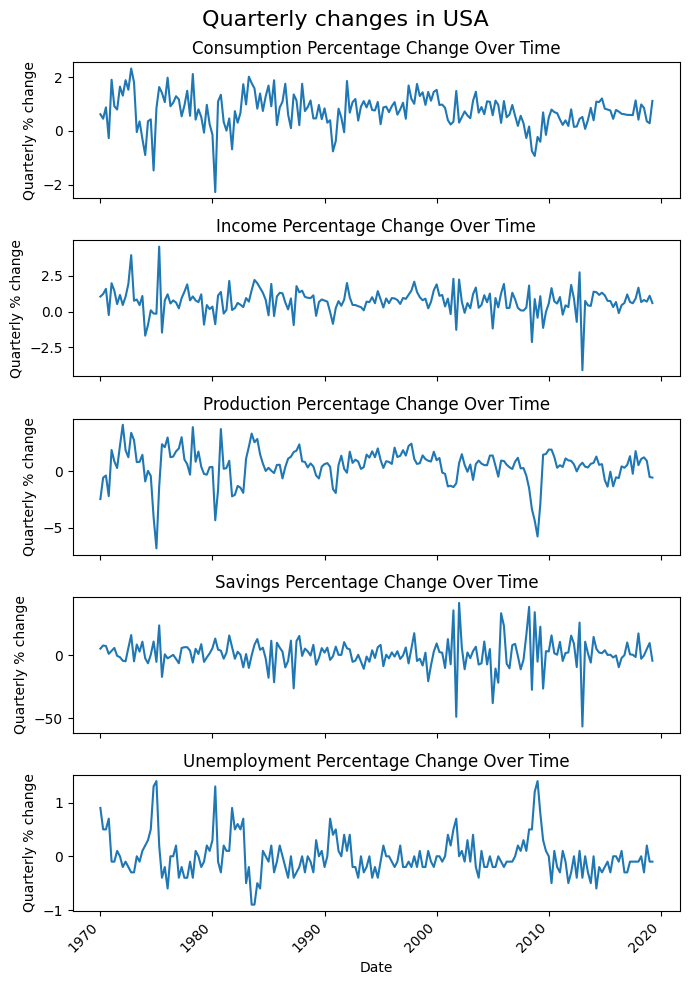

In [10]:
#데이터 시각화
fig, axes = plt.subplots(us_change.shape[1], 1, figsize=(7, 10), sharex=True)

for i, var in enumerate(us_change.columns):
    axes[i].plot(us_change[var], label=var)
    axes[i].set_ylabel("Quarterly % change")
    axes[i].set_title(f'{var} Percentage Change Over Time')

axes[-1].set_xlabel('Date')
plt.setp(axes[-1].get_xticklabels(), rotation=45, ha='right')

plt.suptitle("Quarterly changes in USA", fontsize=16)
plt.tight_layout()
plt.show()

### 3) 정상성 확인

In [12]:
#Adfuller test
print(adfuller(us_change["Consumption"])[1])

0.0001237324092713116


### 4) 최적의 SARIMA(p, d, q), (P, D, Q, S) 모델 선택

In [13]:
#ARIMA 파라미터 최적화 함수
def ARIMAX_optimizer(y, X):
    result= []
    for p in range(4):
        for q in range(4):
            try:
                model = SARIMAX(y, X, order=(p, 0, q), simple_differencing=False).fit(dips=False)
            except:
                continue

            aic = model.aic
            result.append([p, q, aic])

    result_df = pd.DataFrame(result)
    result_df.columns = ['p', 'q', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [14]:
#오차 차수 최적화하기
result = ARIMAX_optimizer(us_change["Consumption"], us_change[ ["Income", "Production", "Savings", "Unemployment"] ])
result

,p,q,AIC
0,2,2,112.974286
1,2,3,114.762318
2,2,1,115.101881
3,3,2,117.538394
4,3,1,118.221254
5,3,3,120.239590
6,3,0,144.953644
7,2,0,146.860193
8,0,2,148.947838
9,1,1,149.570145


### 5) 모델 적합 결과

In [15]:
#실제 모델 적합
model = SARIMAX(us_change["Consumption"], us_change[ ["Income", "Production", "Savings", "Unemployment"] ], order=(2, 0, 2), simple_differencing=False)
fit = model.fit(disp=False)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  198
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 -47.487
Date:                Tue, 31 Dec 2024   AIC                            112.974
Time:                        16:22:05   BIC                            142.569
Sample:                    01-01-1970   HQIC                           124.953
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Income           0.7275      0.029     24.742      0.000       0.670       0.785
Production       0.0454      0.028      1.621      0.105      -0.009       0.100
Savings         -0.0521      0.002    -26.246      0.000      -0.056      -0.048
Unemployment    -0.1938      0.139     -1.390      0.165      -0.467       0.080
ar.L1            0.0093      0.018      0.515      0.607      -0.026       0.045
ar.L2            0.9900      0.018     54.927      0.000       0.955       1.025
ma.L1           -0.0086      0.044     -0.196      0.845      -0.095       0.078
ma.L2           -0.9458      0.045    -21.125      0.000      -1.034      -0.858
sigma2           0.0935      0.008     11.550      0.000       0.078       0.109
===================================================================================
Ljung-Box (L1) (Q):                   1.82   Jarque-Bera (JB):                25.21
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             0.39
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 6) 모델 적합성 검증

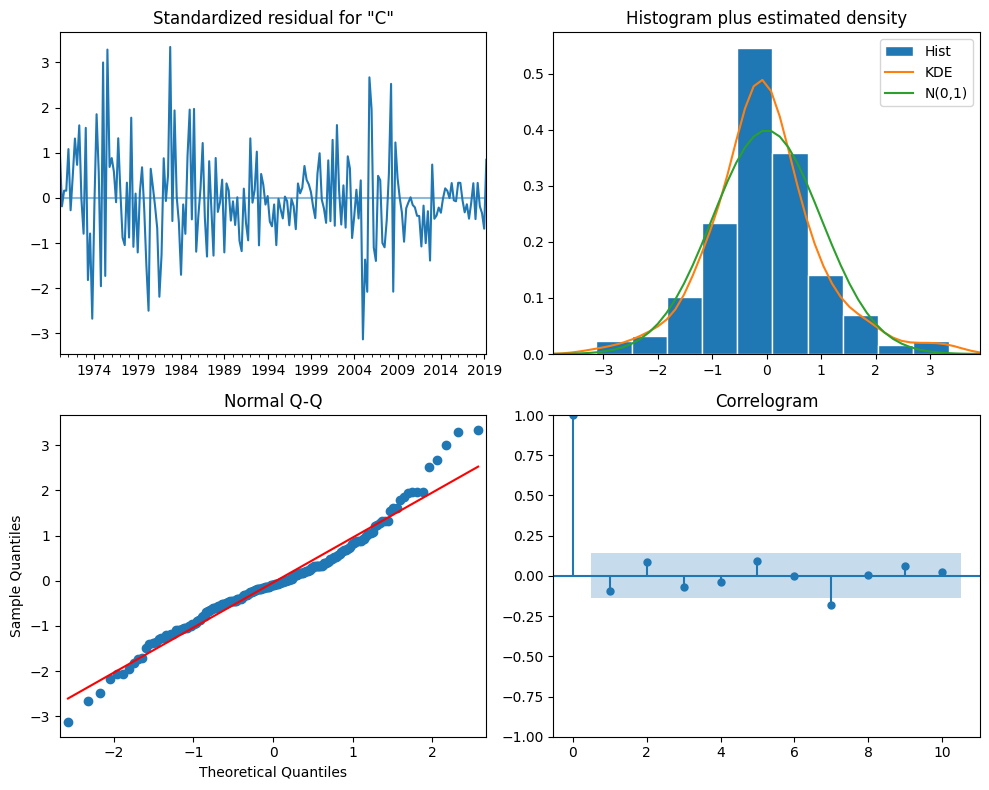

In [16]:
#잔차 확인
fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

### 7) 모델을 이용한 예측

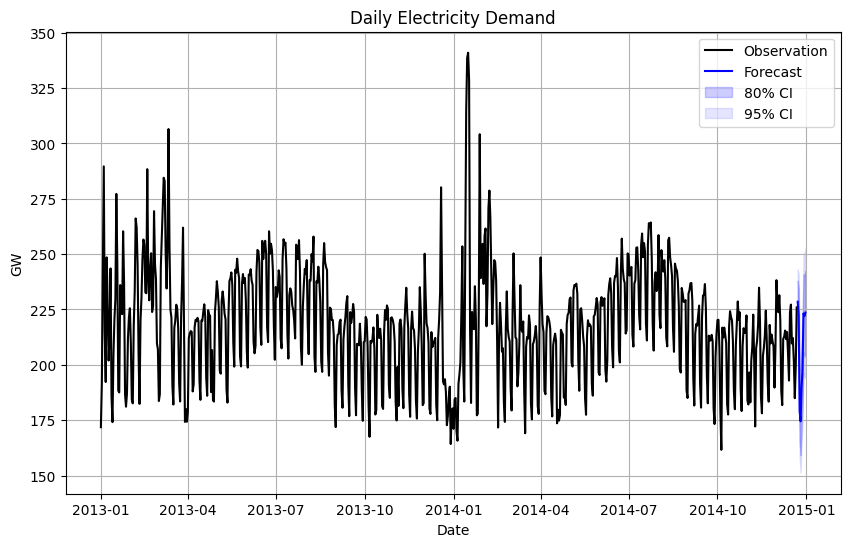

In [11]:
#SARIMAX 예측값 구하기기
forecast_result = fit.get_forecast(steps=9, exog=X[-9:])
forecast_mean = forecast_result.predicted_mean
lower_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 0]
upper_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 1]
lower_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 0]
upper_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 1]

#예측 시각화화
plt.figure(figsize=(10, 6))
plt.plot(vic_elec_daily['Demand'][:-9], label='Observation', color='black')
plt.plot(forecast_mean, label='Forecast', color='b')
plt.fill_between(forecast_mean.index, lower_ci80, upper_ci80, label='80% CI', color='b', alpha=.2)
plt.fill_between(forecast_mean.index, lower_ci95, upper_ci95, label='95% CI', color='b', alpha=.1)
plt.xlabel('Date')
plt.ylabel('GW')
plt.title('Daily Electricity Demand')
plt.grid(True)
plt.legend()
plt.show()

# 4.3.3. VAR

## 가처분 소득 변화와 실질 소비 변화에 대한 VAR 예측

### 1) 모듈과 데이터 불러오기

In [29]:
#모듈 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests

import warnings
warnings.filterwarnings('ignore')

In [14]:
#데이터 불러오기
macro_econ_data = sm.datasets.macrodata.load_pandas().data
dpi_cons_quarter = macro_econ_data[['realdpi', 'realcons']]
dpi_cons_quarter.index = pd.date_range(start='1959/01/01', end='2009/09/30', freq='3MS')
dpi_cons_quarter

,realdpi,realcons
1959-01-01,1886.9,1707.4
1959-04-01,1919.7,1733.7
1959-07-01,1916.4,1751.8
1959-10-01,1931.3,1753.7
1960-01-01,1955.5,1770.5
...,...,...
2008-07-01,9838.3,9267.7
2008-10-01,9920.4,9195.3
2009-01-01,9926.4,9209.2
2009-04-01,10077.5,9189.0


### 2) 가처분 소득과 실질 소비 시각화

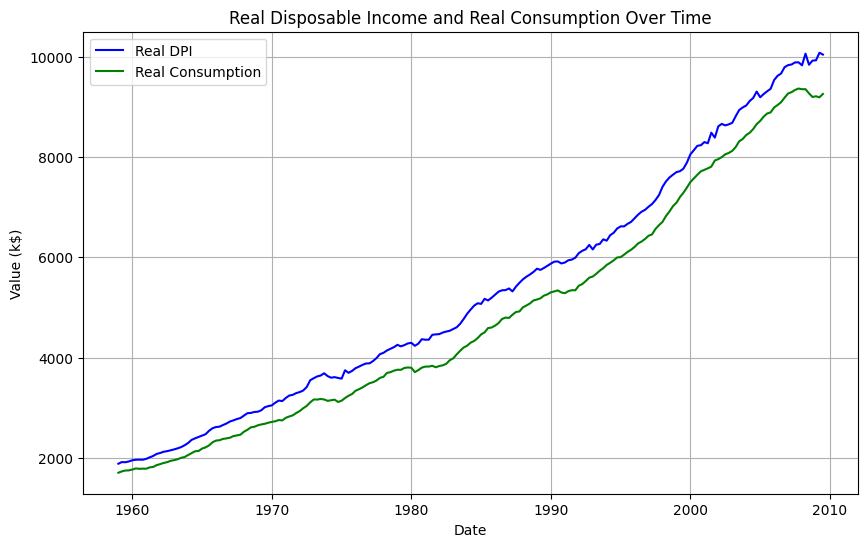

In [17]:
#데이터 시각화
plt.figure(figsize=(10, 6))
plt.plot(dpi_cons_quarter['realdpi'],  color='b', label='Real DPI')
plt.plot(dpi_cons_quarter['realcons'],  color='g', label='Real Consumption')
plt.xlabel("Date")
plt.ylabel("Value (k$)")
plt.title("Real Disposable Income and Real Consumption Over Time")
plt.grid(True)
plt.legend()
plt.show()

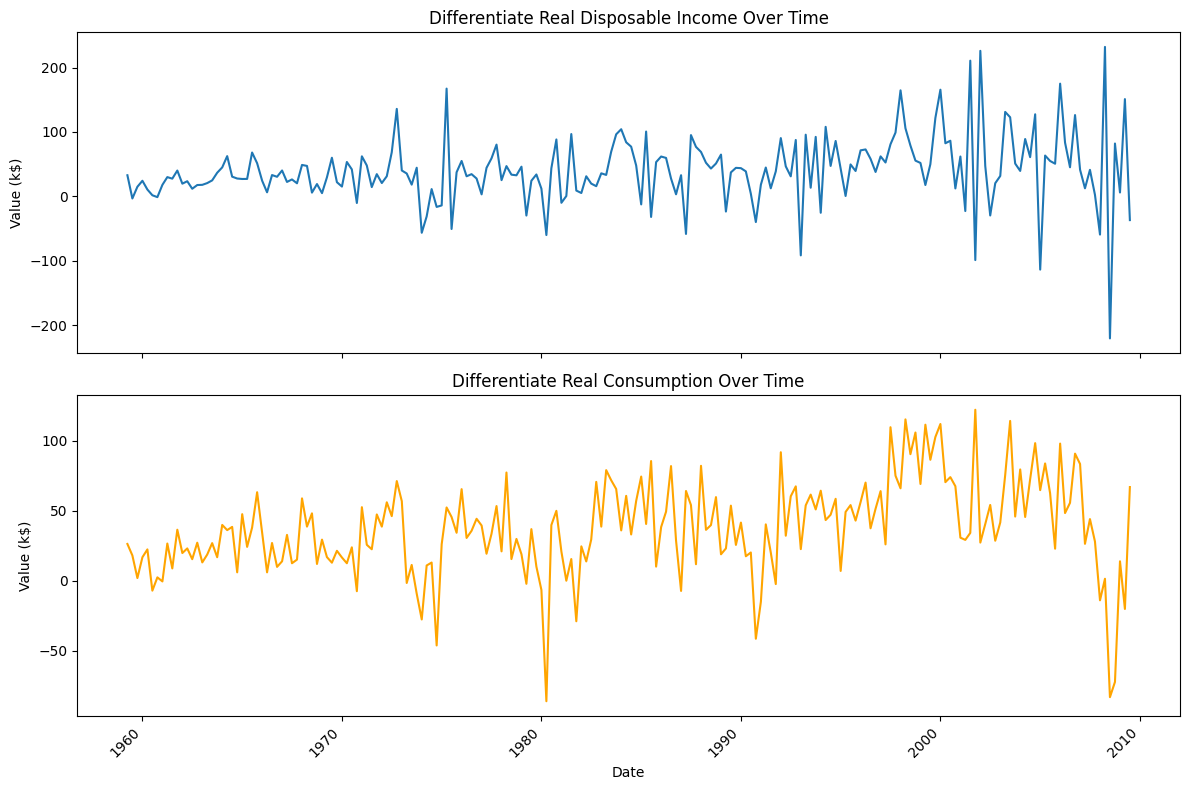

In [61]:
#1차 차분화 데이터 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(dpi_cons_quarter['realdpi'].diff()[1:], label='Real DPI')
ax1.set_ylabel('Value (k$)')
ax1.set_title('Differentiate Real Disposable Income Over Time')

ax2.plot(dpi_cons_quarter['realcons'].diff()[1:], label='Real Consumption', color='orange')
ax2.set_ylabel('Value (k$)')
ax2.set_title('Differentiate Real Consumption Over Time')

ax2.set_xlabel('Date')

plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()

### 3) 정상성 확인

In [21]:
#Adfuller test
print(adfuller(dpi_cons_quarter['realdpi'].diff()[1:][:180])[1])
print(adfuller(dpi_cons_quarter['realcons'].diff()[1:][:180])[1])

1.1698513528678687e-11
0.005911782900179311


### 4) 최적의 VAR(p) 모델 선택

In [23]:
#VAR 파라미터 최적화 함수
def VAR_optimizer(series):
    result= []
    for p in range(10):
        try:
            model = VARMAX(series, order=(p, 0)).fit(dips=False)
        except:
            continue

        aic = model.aic
        result.append([p, aic])

    result_df = pd.DataFrame(result)
    result_df.columns = ['p', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [24]:
#VAR 파라미터 최적화하기
result = VAR_optimizer(dpi_cons_quarter.diff()[1:][:180])
result

,p,AIC
0,3,3527.479734
1,6,3529.923785
2,4,3531.649739
3,5,3531.862367
4,8,3535.353965
5,7,3536.462469
6,2,3538.155109
7,9,3538.887452
8,1,3540.649008


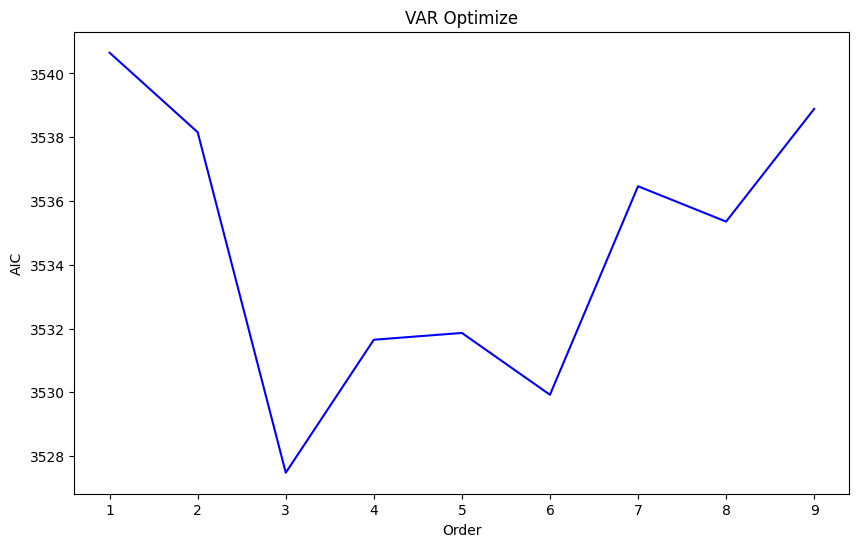

In [28]:
#VAR 최적화 시각화하기
result = result.sort_values(by='p', ascending=True).reset_index(drop=True)
plt.figure(figsize=(10, 6))
plt.plot(result['p'], result['AIC'], color='b', )
plt.xlabel("Order")
plt.ylabel("AIC")
plt.title("VAR Optimize")
plt.show()

### 5) 그레인저 인과관계 테스트

In [30]:
print(grangercausalitytests(dpi_cons_quarter[['realdpi', 'realcons']].diff()[1:][:180], [3]))
print(grangercausalitytests(dpi_cons_quarter[['realcons', 'realdpi']].diff()[1:][:180], [3]))


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=12.9621 , p=0.0000  , df_denom=170, df_num=3
ssr based chi2 test:   chi2=40.4875 , p=0.0000  , df=3
likelihood ratio test: chi2=36.4605 , p=0.0000  , df=3
parameter F test:         F=12.9621 , p=0.0000  , df_denom=170, df_num=3
{np.int64(3): ({'ssr_ftest': (np.float64(12.962109059489094), np.float64(1.1494011565389888e-07), np.float64(170.0), np.int64(3)), 'ssr_chi2test': (np.float64(40.487528885815934), np.float64(8.398472694334837e-09), np.int64(3)), 'lrtest': (np.float64(36.46054468033162), np.float64(5.984129087710511e-08), np.int64(3)), 'params_ftest': (np.float64(12.962109059489125), np.float64(1.149401156538946e-07), np.float64(170.0), 3.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002621D565A90>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000026218E02790>, array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       

### 6) 모델 적합 결과

In [37]:
#실제 모델 적합
model = VARMAX(dpi_cons_quarter.diff()[1:][:180], order=(3, 0))
fit = model.fit()
print(fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  180
Model:                              VAR(3)   Log Likelihood               -1746.740
                               + intercept   AIC                           3527.480
Date:                     Mon, 30 Dec 2024   BIC                           3581.760
Time:                             20:10:16   HQIC                          3549.488
Sample:                         04-01-1959                                         
                              - 01-01-2004                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.06, 0.00   Jarque-Bera (JB):         31.88, 10.85
Prob(Q):                        0.80, 0.96   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         4.52, 2.45   Skew:                      0.38

### 7) 모델 적합성 검증

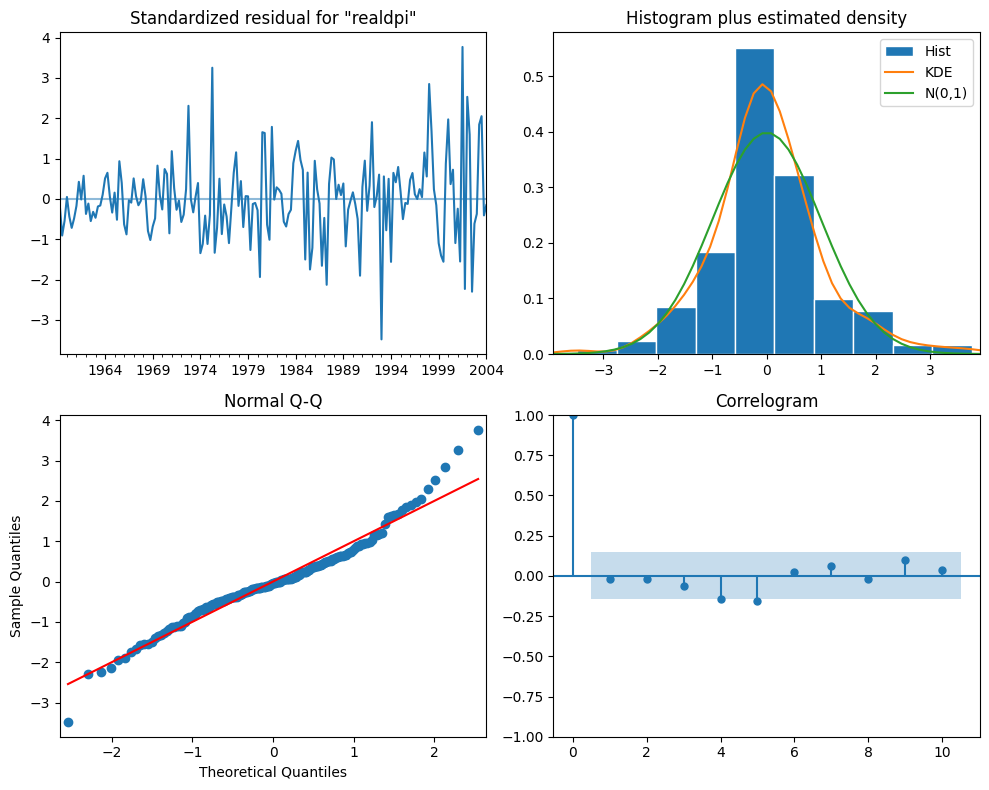

In [38]:
#가처분 소득 모델 잔차 확인
fit.plot_diagnostics(figsize=(10,8), variable=0)
plt.tight_layout()
plt.show()

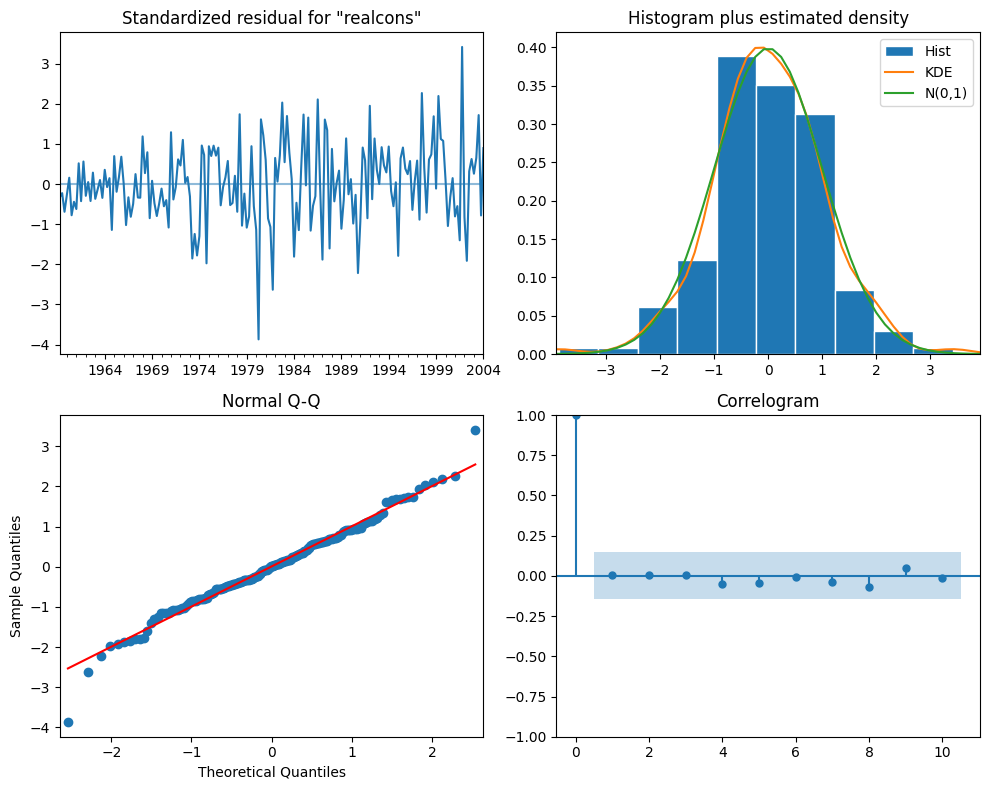

In [39]:
#실질 소비 모델 잔차 확인
fit.plot_diagnostics(figsize=(10,8), variable=1)
plt.tight_layout()
plt.show()

### 8) 모델을 이용한 예측

In [54]:
#VAR 예측값 구하기기
forecast_result = fit.get_forecast(steps=22)

forecast_mean = forecast_result.predicted_mean
cum_forecast_result = forecast_mean.cumsum()
cum_forecast_result['realdpi'] = cum_forecast_result['realdpi'] + dpi_cons_quarter.iloc[179, 0]
cum_forecast_result['realcons'] = cum_forecast_result['realcons'] + dpi_cons_quarter.iloc[179, 1]

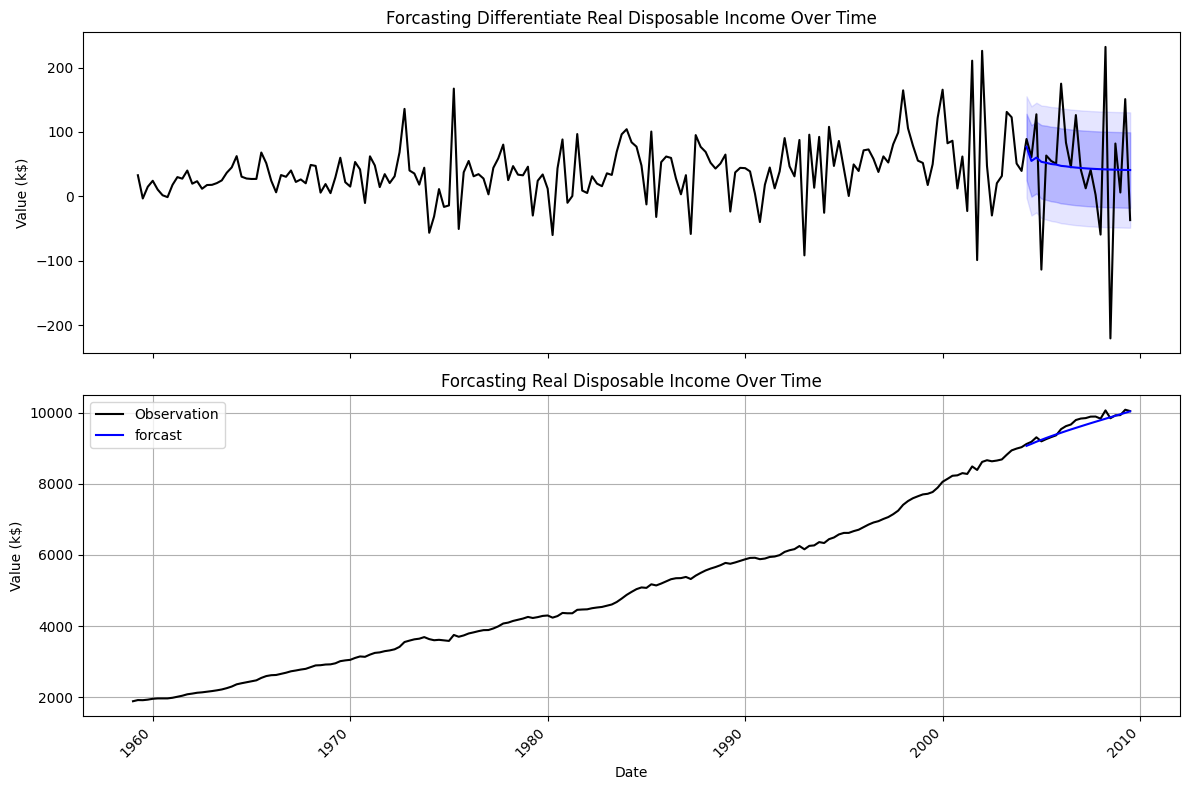

In [57]:
#가처분 소득 신뢰구간
lower_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 0]
upper_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 2]
lower_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 0]
upper_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 2]

#예측 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(dpi_cons_quarter['realdpi'].diff()[1:], label='Observation', color='black')
ax1.plot(forecast_mean['realdpi'], label='forcast', color='b')
ax1.fill_between(forecast_mean.index, lower_ci80, upper_ci80, label='80% CI', color='b', alpha=.2)
ax1.fill_between(forecast_mean.index, lower_ci95, upper_ci95, label='95% CI', color='b', alpha=.1)
ax1.set_ylabel('Value (k$)')
ax1.set_title('Forcasting Differentiate Real Disposable Income Over Time')

ax2.plot(dpi_cons_quarter['realdpi'], label='Observation', color='black')
ax2.plot(cum_forecast_result['realdpi'], label='forcast', color='b')
ax2.set_ylabel('Value (k$)')
ax2.set_title('Forcasting Real Disposable Income Over Time')

ax2.set_xlabel('Date')

plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()

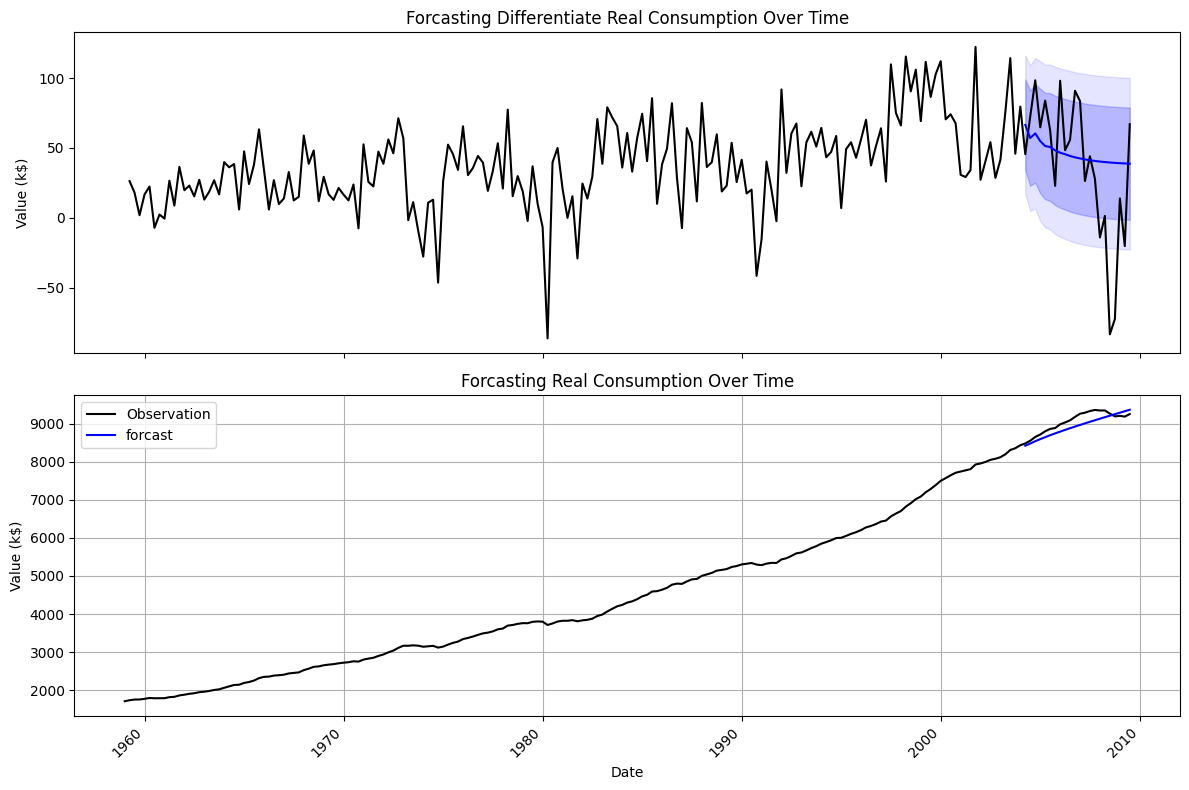

In [59]:
#실질소비 소득 신뢰구간
lower_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 1]
upper_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 3]
lower_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 1]
upper_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 3]

#예측 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(dpi_cons_quarter['realcons'].diff()[1:], label='Observation', color='black')
ax1.plot(forecast_mean['realcons'], label='forcast', color='b')
ax1.fill_between(forecast_mean.index, lower_ci80, upper_ci80, label='80% CI', color='b', alpha=.2)
ax1.fill_between(forecast_mean.index, lower_ci95, upper_ci95, label='95% CI', color='b', alpha=.1)
ax1.set_ylabel('Value (k$)')
ax1.set_title('Forcasting Differentiate Real Consumption Over Time')

ax2.plot(dpi_cons_quarter['realcons'], label='Observation', color='black')
ax2.plot(cum_forecast_result['realcons'], label='forcast', color='b')
ax2.set_ylabel('Value (k$)')
ax2.set_title('Forcasting Real Consumption Over Time')

ax2.set_xlabel('Date')

plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()